In [15]:
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import mse, rmse


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [5]:
absent = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv",
    sep=";",
)
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [6]:
drop_cols = [
    "Body mass index",   
    "Age",               
    "ID"                 
]

cat_cols = ["Reason for absence"]

bin_cols = [
    "Disciplinary failure",
    "Education",
    "Social drinker",
    "Social smoker",
    "Pet",
]

num_cols = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Service time",
    "Work load Average/day ",
    "Hit target",
    "Son",
    "Weight",
    "Height",
]

time_cols = ["Month of absence", "Day of the week", "Seasons"]
num_cols += time_cols

In [7]:
X = absent.drop(columns=drop_cols).drop(columns=["Absenteeism time in hours"])
y = absent["Absenteeism time in hours"]

log_y = np.log(y + 1)

print_vif(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, log_y, test_size=0.2, random_state=42
)

VIF results
-------------------------------
const                              2305.852591
Reason for absence                    1.555474
Month of absence                      1.803798
Day of the week                       1.072930
Seasons                               1.392608
Transportation expense                1.768474
Distance from Residence to Work       2.032873
Service time                          2.309152
Work load Average/day                 1.238215
Hit target                            1.449920
Disciplinary failure                  1.536207
Education                             1.455210
Son                                   1.374966
Social drinker                        2.435255
Social smoker                         1.242629
Pet                                   1.668242
Weight                                2.089478
Height                                1.765236
dtype: float64
-------------------------------



In [8]:
col_transformer = ColumnTransformer(
    [
        ("encode_cats", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("scale_nums", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("feat_scale_encode", col_transformer),
        ("feat_selection", SelectKBest(f_regression)),
        ("knn", KNeighborsRegressor()),
    ]
)

grid = {
    "feat_selection__k": range(2, 10),
    "knn__n_neighbors": range(2, 31),
    "knn__weights": ["uniform", "distance"],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

print("Best Params:")
print(pipeline_cv.best_params_)

Fitting 5 folds for each of 464 candidates, totalling 2320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Params:
{'feat_selection__k': 9, 'knn__n_neighbors': 15, 'knn__weights': 'distance'}


[Parallel(n_jobs=1)]: Done 2320 out of 2320 | elapsed:  1.2min finished



train_score: 0.49326657141166225
test_score: 0.4572813816801913
transformed y
rmse 0.62
mae 0.40
mape 0.33


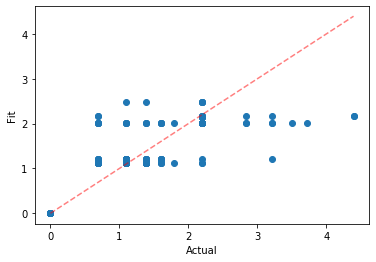

untransformed y
rmse 9.93
mae 3.54
mape 0.77


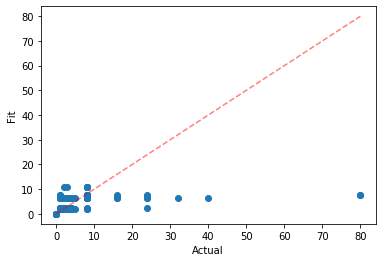

In [9]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"\ntrain_score: {train_score}")
print(f"test_score: {test_score}")

y_pred = pipeline_cv.predict(X_test)

print("transformed y")
eval_preds(y_test, y_pred)

print("untransformed y")
eval_preds(np.exp(y_test) - 1, np.exp(y_pred) - 1)

In [13]:
X = absent.drop(columns=drop_cols).drop(columns=["Absenteeism time in hours"])
y = absent["Absenteeism time in hours"]

log_y = np.log(y + 1)



X_train, X_test, y_train, y_test = train_test_split(
    X, log_y, test_size=0.2, random_state=42
)

X_train_const= sm.add_constant(X)
lm_results= sm.OLS(y,X_train_const).fit()

In [14]:
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism time in hours   R-squared:                       0.149
Model:                                   OLS   Adj. R-squared:                  0.129
Method:                        Least Squares   F-statistic:                     7.453
Date:                       Sun, 19 Apr 2020   Prob (F-statistic):           3.83e-17
Time:                               20:28:46   Log-Likelihood:                -2906.4
No. Observations:                        740   AIC:                             5849.
Df Residuals:                            722   BIC:                             5932.
Df Model:                                 17                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             -25.5678     21.959     -1.164      0.245     -68.679      17.543
Reason for absence                 -0.5032      0.068     -7.436      0.000      -0.636      -0.370
Month of absence                    0.1540      0.179      0.861      0.390      -0.197       0.505
Day of the week                    -0.8802      0.333     -2.640      0.008      -1.535      -0.226
Seasons                            -0.1299      0.486     -0.267      0.789      -1.083       0.824
Transportation expense              0.0055      0.009      0.610      0.542      -0.012       0.023
Distance from Residence to Work    -0.0767      0.044     -1.744      0.082      -0.163       0.010
Service time                        0.1976      0.159      1.246      0.213      -0.114       0.509
Work load Average/day              -0.0056      0.013     -0.432      0.666      -0.031       0.020
Hit target                          0.1226      0.146      0.841      0.401      -0.164       0.409
Disciplinary failure              -18.0772      2.507     -7.212      0.000     -22.998     -13.156
Education                          -1.3324      0.820     -1.625      0.105      -2.942       0.277
Son                                 1.1093      0.488      2.271      0.023       0.150       2.068
Social drinker                      2.0850      1.440      1.447      0.148      -0.743       4.913
Social smoker                      -2.0705      1.960     -1.056      0.291      -5.918       1.777
Pet                                -0.0706      0.448     -0.158      0.875      -0.951       0.810
Weight                             -0.0837      0.051     -1.629      0.104      -0.184       0.017
Height                              0.2362      0.101      2.345      0.019       0.038       0.434
==============================================================================
Omnibus:                      812.454   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44265.165
Skew:                           5.335   Prob(JB):                         0.00
Kurtosis:                      39.356   Cond. No.                     1.99e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""